# Panan005 Absolute Speed Retry

In [1]:
import intake
from pathlib import Path
import numpy as np
import xarray as xr

import xgcm
import cf_xarray

# For plotting
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import matplotlib.path as mpath
import cmocean as cm
import pyproj
import cartopy.feature as cft
import glob

In [2]:
#Starting a dask client
from os import environ
environ["PYTHONWARNINGS"] = "ignore"

from dask.distributed import Client
client = Client(threads_per_worker=1)
client

/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 39903 instead
  warnings.warn(


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/39903/status,
Dashboard: /proxy/39903/status,Workers: 28
Total threads: 28,Total memory: 125.19 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:41957,Workers: 28
Dashboard: /proxy/39903/status,Total threads: 28
Started: Just now,Total memory: 125.19 GiB
Comm: tcp://127.0.0.1:42961,Total threads: 1
Dashboard: /proxy/35291/status,Memory: 4.47 GiB
Nanny: tcp://127.0.0.1:44383,


I am looking at 2009 - 2010 and just the top 200m. 

In [3]:
pathsC = np.sort(glob.glob('/g/data/ol01/outputs/mom6-panan/panant-005-zstar-ACCESSyr2/*/*ocean_month_z.nc'))
pathsMW = np.sort(glob.glob('/g/data/g40/akm157/model_output/mom6-panan/panant-005-zstar-ssp126-MW-only/*/*ocean_month_z.nc'))

In [7]:
def preprocessC(control):
    control = control[['uo', 'vo']].sel(z_l=slice(0,220)).mean(dim='z_l')
    return control

def preprocessMW(perturbation):
    perturbation = perturbation[['uo', 'vo']].sel(z_l=slice(0,220)).mean(dim='z_l')
    return perturbation

In [5]:
path_to_ocean_static_MW = Path('/g/data/g40/akm157/model_output/mom6-panan/panant-005-zstar-ssp126-MW-only/output120/20010101.ocean_static.nc')
ocean_static_MW = xr.open_dataset(path_to_ocean_static_MW)
path_to_ocean_static_C = Path('/g/data/ol01/outputs/mom6-panan/panant-005-zstar-ACCESSyr2/output021/19921001.ocean_static.nc')
ocean_static_C = xr.open_dataset(path_to_ocean_static_C)

In [8]:
control = xr.open_mfdataset(pathsC, preprocess = preprocessC)
perturbation = xr.open_mfdataset(pathsMW, preprocess = preprocessMW)

control = control.sel(time=slice('2009-01-01','2010-12-31')).mean(dim='time')
perturbation = perturbation.sel(time=slice('2009-01-01','2010-12-31')).mean(dim='time')

control = control.isel(xq = slice(1, None), yq = slice(1, None))
perturbation = perturbation.isel(xq = slice(1, None), yq = slice(1, None))

In [9]:
ocean_static_MW = ocean_static_MW.sel(xq = perturbation['xq'], xh = perturbation['xh'], 
                                      yq = perturbation['yq'], yh = perturbation['yh'])
grid_MW = xgcm.Grid(ocean_static_MW, coords = {'X': {'center': 'xh', 'right': 'xq'},
                                               'Y': {'center': 'yh', 'right': 'yq'}}, periodic = ['X'])

ocean_static_C = ocean_static_C.sel(xq = control['xq'], xh = control['xh'], 
                                    yq = control['yq'], yh = control['yh'])
grid_C = xgcm.Grid(ocean_static_C, coords = {'X': {'center': 'xh', 'right': 'xq'},
                                             'Y': {'center': 'yh', 'right': 'yq'}}, periodic = ['X'])

In [10]:
uC_int = grid_C.interp(control['uo'], 'X')
vC_int = grid_C.interp(control['vo'], 'Y')
uMW_int = grid_MW.interp(perturbation['uo'], 'X')
vMW_int = grid_MW.interp(perturbation['vo'], 'Y')

/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/xgcm/grid_ufunc.py:832: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  out_dim: grid._ds.dims[out_dim] for arg in out_core_dims for out_dim in arg
/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/xgcm/grid_ufunc.py:832: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  out_dim: grid._ds.dims[out_dim] for arg in out_core_dims for out_dim in arg
/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/xgcm/grid_ufunc.py:832: FutureWarning: The return

In [11]:
u_anom = uMW_int - uC_int
v_anom = vMW_int - vC_int

In [12]:
u_anom = u_anom.load()
v_anom = v_anom.load()

/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/distributed/client.py:3357: UserWarning: Sending large graph of size 22.81 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/distributed/client.py:3357: UserWarning: Sending large graph of size 22.91 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


In [16]:
u_anom.to_netcdf('/g/data/g40/kc5856/access_panan_ssp126_SWMT/pan005_u_anom.nc')
v_anom.to_netcdf('/g/data/g40/kc5856/access_panan_ssp126_SWMT/pan005_v_anom.nc')

In [17]:
abs_C = np.sqrt(uC_int**2 + vC_int**2)
abs_MW = np.sqrt(uMW_int**2 + vMW_int**2)

In [18]:
abs_anom = abs_MW - abs_C
abs_anom = abs_anom.load()

/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/distributed/client.py:3357: UserWarning: Sending large graph of size 48.16 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


In [19]:
abs_anom.to_netcdf('/g/data/g40/kc5856/access_panan_ssp126_SWMT/pan005_abs_anom.nc')

In [21]:
land_50m = cft.NaturalEarthFeature("physical", "land", "50m", edgecolor="black", facecolor="papayawhip", linewidth=0.5)
projection = ccrs.SouthPolarStereo()

In [24]:
pancontrol005 = intake.open_esm_datastore('/home/272/kc5856/catalog_dir/panant_005_zstar_access_yr2.json', columns_with_iterables=['variable'])
data_fixed = pancontrol005.search(variable=["areacello","deptho"],path=".*output021.*").to_dask()

In [25]:
def shelf_mask_isobath(var, model_dict):

    paths = {
             "mom5": "/g/data/ik11/grids/Antarctic_slope_contour_1000m.npz",
             "mom6": "/g/data/ik11/grids/Antarctic_slope_contour_1000m_MOM6_01deg.nc",
            "mom6_005": "/g/data/ik11/grids/Antarctic_slope_contour_1000m_MOM6_005deg.nc"
             }

    var = var.cf.sel({'latitude': slice(-90, -59)})

    if paths[model_dict][-3:] == '.nc':
        shelf_mask = xr.open_dataset(paths[model_dict])['contour_masked_above']
    else:
        contour_file = np.load(paths[model_dict])
        shelf_mask = xr.DataArray(contour_file['contour_masked_above'],
                                  coords = var.coords, 
                                  dims = var.dims,
                                  name = 'contour_masked_above')
    
    shelf_mask = xr.where(shelf_mask == 0, 1, 0)
    masked_var = var * shelf_mask
    
    return masked_var, shelf_mask

In [26]:
depth = data_fixed.deptho
land_mask = (depth*0).fillna(1)
depth_shelf, shelf_mask = shelf_mask_isobath(depth, 'mom6')

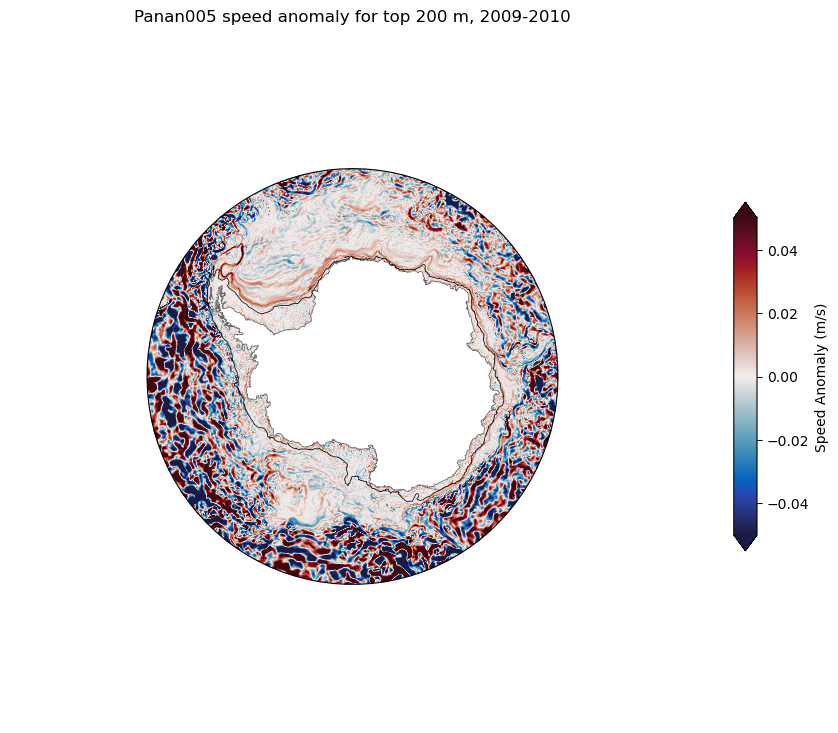

In [28]:
plt.figure(figsize=(10, 9))
ax = plt.axes(projection=projection)

ax.set_extent([-280, 80, -80, -35], crs=ccrs.PlateCarree())

# Compute a circle in axes coordinates, which we can use as a boundary for the map. 
theta = np.linspace(0, 2 * np.pi, 100)
center, radius = [0.5, 0.5], 0.3
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)
ax.set_boundary(circle, transform=ax.transAxes)

ax.contour(land_mask.cf['X'], land_mask.cf['Y'], land_mask,
           levels = [0, 1], colors = 'dimgrey',linewidths=0.5, transform = ccrs.PlateCarree())
ax.contour(shelf_mask.cf['X'], shelf_mask.cf['Y'], shelf_mask,
           levels = [0, 1], colors = 'black', linewidths=0.5,transform = ccrs.PlateCarree())

abs_anom.plot(
    x="xh",
    y="yh",
    transform=ccrs.PlateCarree(),
    vmin=-0.05,
    vmax=0.05,
    extend="both",
    cmap=cm.cm.balance, #cm ocean colour maps for more options, matplotlib has more also.
    cbar_kwargs={"label": "Speed Anomaly (m/s)", "fraction": 0.03, "aspect": 15, "shrink": 0.7},
);

plt.title("Panan005 speed anomaly for top 200 m, 2009-2010");